In [103]:
import pandas as pd

df = pd.read_csv("../csv/split_data.csv")
df = df[df["split"] == "training"]
df["breast_birads"].value_counts()

breast_birads
BI-RADS 1    8609
BI-RADS 2    2956
BI-RADS 3     594
BI-RADS 4     493
BI-RADS 5     148
Name: count, dtype: int64

In [104]:
sampled_df = df.groupby('breast_birads', group_keys=False).apply(lambda x: x.sample(min(len(x), 200))).reset_index(drop=True)
print(sampled_df["breast_birads"].value_counts())

breast_birads
BI-RADS 1    200
BI-RADS 2    200
BI-RADS 3    200
BI-RADS 4    200
BI-RADS 5    148
Name: count, dtype: int64


In [105]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os
import torch

mean = [0.6821, 0.4575, 0.2626]
std  = [0.1324, 0.1306, 0.1022]

class Mydataset(Dataset):
    def __init__(self, df, root):
        super(Mydataset, self).__init__()
        self.root = root
        image_paths_df = df["study_id"] + "/" + df["image_id"] +".png"
        self.image_paths = image_paths_df.tolist()
        label_df = df["breast_birads"]
        self.labels = label_df.tolist()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.image_paths[idx])
        img = self._read_image(img_path, (224,224))
        label = int(self.labels[idx][-1])
        return img, torch.tensor(label).to(torch.long)
    
    def _read_image(self, filepath, new_size):
        image_pil = Image.open(filepath)
        
        # Kiểm tra chế độ của ảnh
        if image_pil.mode != 'L':
            image_pil = image_pil.convert('L')  # Chuyển đổi sang chế độ 'L' (grayscale) nếu cần thiết
        
        # Tạo ảnh RGB từ ảnh đơn kênh bằng cách sao chép giá trị của kênh đó vào cả ba kênh
        image_pil = Image.merge('RGB', (image_pil, image_pil, image_pil))
        
        # Resize ảnh
        transform = transforms.Compose([
            transforms.Resize((450,200)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        resized_image = transform(image_pil)
        resized_image = resized_image.to(torch.float)
        
        return resized_image
        

In [106]:
from torch import nn
import torch
import torchvision.models as models
import timm

class FeatureExtractModel(nn.Module):
    def __init__(self, model_name: str, embed_dim: int):
        """
        A custom model for Setting 3, which uses different pre-trained models
        based on the specified `model_name`.

        Args:
        - model_name: Name of the pre-trained model to be used
        - embed_dim: Dimension of the output embeddings
        """
        super(FeatureExtractModel, self).__init__()
        self.model_name = model_name
        # Load the specified pre-trained model
        if model_name.startswith('resnet'):
            if model_name == 'resnet50':
                self.model = models.resnet50(pretrained=True)
            elif model_name == 'resnet101':
                self.model = models.resnet101(pretrained=True)
            elif model_name == 'resnet152':
                self.model = models.resnet152(pretrained=True)
            else:
                raise ValueError(f"Unsupported ResNet model: {model_name}")
                
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('densenet'):
            if model_name == 'densenet121':
                self.model = models.densenet121(pretrained=True)
            else:
                raise ValueError(f"Unsupported DenseNet model: {model_name}")
                
            num_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('vit'):
            self.model = timm.create_model(model_name, pretrained=True)

            num_features = self.model.head.in_features
            self.model.head = nn.Linear(num_features, embed_dim)
        
        else:
            raise ValueError(f"Unsupported model: {model_name}")
    
    def forward(self, image):
        return self.model(image)

In [107]:
from torch.utils.data import DataLoader
import os

dataset = Mydataset(sampled_df, "/media/jackson/Data/archive/Processed_Images")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count())

model = FeatureExtractModel("resnet50", 512)
check_point = torch.load("../resnet50BasedModel/best.pt", map_location = torch.device("cpu"))
model.load_state_dict(check_point["model_state_dict"])

/home/jackson/anaconda3/envs/Paper/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jackson/anaconda3/envs/Paper/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [117]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Lấy embeddings từ mô hình
test_targets = []
test_embeddings = torch.zeros((0, 512))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model = model.to(device)
with torch.no_grad():
    for data in tqdm(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        output = model(inputs)
        test_targets.append(labels)
        test_embeddings = torch.cat((test_embeddings, output.detach().cpu().flatten().unsqueeze(0)), axis=0)
# Chuyển đổi danh sách thành tensor
test_embeddings = np.array(test_embeddings)
test_targets = np.array(torch.stack(test_targets).flatten())


100%|██████████| 948/948 [00:50<00:00, 18.73it/s]

tensor([[ 3.2541e-01, -3.7975e-02, -2.3620e-03,  ...,  1.4650e-01,
         -3.2216e-01, -2.0651e-01],
        [-1.5750e+00,  1.0863e+00,  6.9542e-01,  ...,  3.4501e-01,
         -5.3932e-01, -9.2343e-02],
        [-1.9090e-01,  9.1071e-01,  2.1396e+00,  ..., -9.2706e+00,
         -1.6207e+00,  3.9857e+00],
        ...,
        [ 1.4626e+00,  2.1507e-01,  6.0332e-01,  ..., -1.2609e+00,
          6.3600e-02, -1.4928e+00],
        [-4.3156e-02,  8.1990e-02, -5.9357e-02,  ..., -9.1782e-02,
         -6.6309e-02,  8.7293e-02],
        [-2.0378e+00,  1.2065e+00,  9.4857e-01,  ..., -1.4683e+00,
         -4.0242e-03, -2.4561e-01]])
948


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 948 samples in 0.001s...
[t-SNE] Computed neighbors for 948 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 948 / 948
[t-SNE] Mean sigma: 0.006409
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.619499
[t-SNE] KL divergence after 1000 iterations: 0.314227


/tmp/ipykernel_5859/3191504078.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


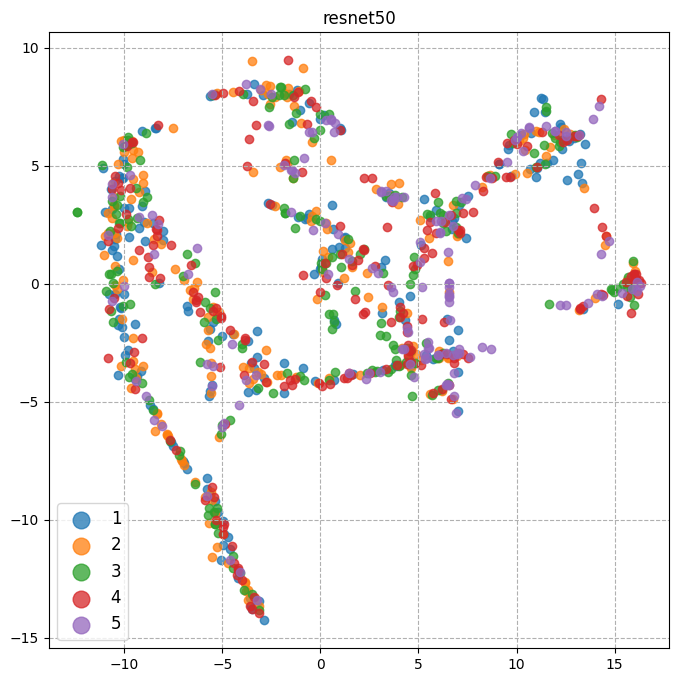

In [122]:
from matplotlib import cm
from sklearn.manifold import TSNE
import numpy as np

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(3, verbose=1, n_iter=1000, init='pca', perplexity=30, early_exaggeration=12, metric="cosine", random_state=123)
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 5
for lab in range(1, num_categories+1):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.75)
ax.legend(fontsize='large', markerscale=2)
plt.grid(linestyle='--')
plt.title(f"{model.model_name}")
plt.show()